In [1]:
import os
import sys
import glob
import scipy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

## Point

In [2]:
STATS_DATA_LOC = '/data8/Human/FungiPaper/Datasheets/SampleMetadata_v1.csv'
COVERAGE_DATA_LOC = '/data8/Human/FungiPaper/Datasheets/MappingListGamma_genomeCoverage_v1.csv'

## Load stats metadata

In [3]:
Gdb = pd.read_csv(STATS_DATA_LOC)

### Determing which samples have Euks

In [4]:
Cdb = pd.read_csv(COVERAGE_DATA_LOC)

In [5]:
# Only genomes taht are at 0.1 breadth in at least one sample
BREADTH = 0.1
Adb = Cdb.copy()
Adb['pp'] = [0 if b <= BREADTH else p for b,p in zip(\
        Adb['breadth'], Adb['relative_abundance'])]
Adb = Adb[Adb['genome'].isin(Cdb['genome'][Cdb['breadth'] >= BREADTH])]

In [6]:
# Sum values
table = defaultdict(list)
for sample, db in Adb.groupby('sample'):
    table['sample'].append(sample)
    table['pp'].append(db['pp'].sum())
ASdb = pd.DataFrame(table)
ASdb['infant'] = [x[:6] for x in ASdb['sample']]

In [7]:
# Pick one sample per infant
table = defaultdict(list)
for inf, db in ASdb.groupby('infant'):
    if db['pp'].max() == 0.0:
        db = db.sample(n=1, random_state=100)
        samp = db['sample'].tolist()[0]
        table['sample'].append(samp)
        table['pp'].append(db['pp'][db['sample'] == samp].tolist()[0])
    else:
        db = db.sort_values('pp', ascending=False)
        samp = db['sample'].tolist()[0]
        table['sample'].append(samp)
        table['pp'].append(db['pp'][db['sample'] == samp].tolist()[0])
RASdb = pd.DataFrame(table)
RASdb['Euk'] = [True if p > 0.1 else False for p in RASdb['pp']]

In [8]:
SAMPLES_WITH_EUK = RASdb['sample'][RASdb['Euk'] == True].tolist()
SAMPLES_WITHOUT_EUK = RASdb['sample'][RASdb['Euk'] == False].tolist()

### Filter metadata 

In [9]:
def filter_giant_sheet(Odb, NECon, NECoff, **kwargs):
    '''
    Filter giant sheet and return filtered sheet
    
    Args:
        Odb: Original giant sheet
        NECon: List of samples associated with NEC
        NECoff: List of samples not associated with NEC
        
    Kwargs:
        Passed to catFilter
    '''
    DBon = Odb[Odb['sample'].isin(NECon)]
    DBoff = Odb[Odb['sample'].isin(NECoff)]
    
    keep = []
    for col in list(Odb.columns):
        if col in ['sample']:
            continue
        typ = col.split('$')[1]
        
        if typ == 'categorical':
            keepCol = _catFilter(DBon[col].tolist(), DBoff[col].tolist(), **kwargs)
            if keepCol:
                keep.append(col)
            else:
                pass
        elif typ == 'continuous':
            keepCol = _conFilter(DBon[col].tolist(), DBoff[col].tolist(), **kwargs)
            if keepCol:
                keep.append(col)
            else:
                pass
    
    Rdb = Odb[['sample'] + keep]
    print("{0:.2f}% of columns filtered out".format(100-(len(Rdb.columns)/len(Odb.columns))*100))
    return Rdb

def _catFilter(onVals, offVals, **kwargs):
    '''
    Return True if keep sample, False if not
    
    Args:
        onVals: list of values of NEC+ samples
        offVals: list of values of NEC- samples
    
    Kwargs:
        minFrac: minimum % of total "True" values
        maxFrac: maximum % of total "True" values
    '''
    minFrac = kwargs.get('minFrac', .1)
    maxFrac = kwargs.get('maxFrac', .9)
    
    True_vals = len([x for x in onVals if x == True] + [x for x in offVals if x == True])
    False_vals = len([x for x in onVals if x == False] + [x for x in offVals if x == False])
    total_vals = True_vals + False_vals
    
    if ((True_vals/total_vals) >= minFrac) & ((True_vals/total_vals) <= maxFrac):
        return True
    else:
        return False
    
def _conFilter(onVals, offVals, **kwargs):
    '''
    Return True if keep sample, False if not
    
    Args:
        onVals: list of values of NEC+ samples
        offVals: list of values of NEC- samples
    
    Kwargs:
        minVal: minimum value to use
        minFrac: minimum % of total values over minVal
        maxNa: maximum % of values that can be NA
    '''
    minVal = kwargs.get('minVal', 0)
    minFrac = kwargs.get('minFrac', .1)
    maxNA = kwargs.get('maxNa', .5)
    
    na_vals = [x for x in (onVals + offVals) if ((x!=x) or (x=='na'))]
    not_na_vals = [float(x) for x in (onVals + offVals) if ((x==x) and (x!='na'))]
    
    Passing_vals = len([x for x in not_na_vals if (x > minVal)])
    total_vals = len(onVals + offVals)
    
    if (len(na_vals)/total_vals) > maxNA:
        return False
    
    if ((Passing_vals/total_vals) >= minFrac):
        return True
    else:
        return False

In [10]:
FGdb = filter_giant_sheet(Gdb, \
               SAMPLES_WITH_EUK,\
               SAMPLES_WITHOUT_EUK,\
               minFrac=.2, maxFrac=.8, maxNa=0.2)

64.86% of columns filtered out


# Run stats

In [17]:
def giantSheetStats(Odb, NECon, NECoff, **kwargs):
    '''
    Run stat tests on the giant sheet
    
    Args:
        Odb: Original giant sheet
        NECon: List of samples associated with NEC
        NECoff: List of samples not associated with NEC
    '''
    table = defaultdict(list)
    
    DBon = Odb[Odb['sample'].isin(NECon)]
    DBoff = Odb[Odb['sample'].isin(NECoff)]
    for col in list(Odb.columns):
        if col in ['sample']:
            continue
            
        typ = col.split('$')[1]
        p = _run_stats(typ, DBon[col].tolist(), DBoff[col].tolist(), **kwargs)
        if p == p:
            table['explVar'].append(col)
            table['p'].append(p)
            table['type'].append(typ)
            table['name'].append(col.split('$')[0])
    
    STdb = pd.DataFrame(table)
    STdb['q'] = p_adjust_bh(STdb['p'])
    #STdb = _sophisticated_pvalue_correction(STdb)
    return STdb

def _run_stats(typ, onVals, offVals, **kwargs):
    '''
    Run the appropriate statistical test and return a p-value
    '''
    if typ == 'categorical':
        r1 = [len([x for x in onVals if x==True]),\
              len([x for x in onVals if x==False])]
        r2 = [len([x for x in offVals if x==True]),\
              len([x for x in offVals if x==False])]
        oddsratio, pvalue = scipy.stats.fisher_exact([r1, r2])
        return pvalue
    
    elif typ == 'continuous':
        n = [x for x in onVals if ((x==x) & (x!='na'))]
        o = [x for x in offVals if ((x==x) & (x!='na'))]
        stat, p = scipy.stats.ranksums(n, o)
        return p
    
def _sophisticated_pvalue_correction(STdb):
    '''
    Correct within category and between category 
    '''
    x2q = {}
    bests = []
    for name, db in STdb.groupby('name'):
        db['q'] = p_adjust_bh(list(db['p']))
        x2q = {**x2q, **db.set_index('explVar')['q'].to_dict()}
        
        best = db.sort_values('p')['explVar'].tolist()[0]
        bests.append(best)
        
    STdb['q'] = STdb['explVar'].map(x2q)
    
    bdb = STdb[[True if x in bests else False for x in STdb['explVar']]]
    bdb['qq'] = p_adjust_bh(list(bdb['q']))
    b2q = bdb.set_index('explVar')['qq'].to_dict()
    
    STdb['qq'] = STdb['explVar'].map(b2q)
    return STdb

def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(float(len(p)), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

In [18]:
FSdb = giantSheetStats(FGdb,\
               SAMPLES_WITH_EUK,\
               SAMPLES_WITHOUT_EUK)
FSdb[~FSdb['q'].isna()].sort_values('q')

,explVar,name,p,type,q
9,SampleMetadata$continuous$daysSinceAb,SampleMetadata,0.000151,continuous,0.001807
3,CatSampleMetadata$categorical$recent_ab,CatSampleMetadata,0.000386,categorical,0.002293
8,SampleMetadata$continuous$seqDepth,SampleMetadata,0.000573,continuous,0.002293
7,SampleMetadata$continuous$assemblyCompleteness,SampleMetadata,0.005000,continuous,0.014999
4,SampleMetadata$continuous$DOL,SampleMetadata,0.015399,continuous,0.036776
11,BacterialNCBITax$continuous$pp_pcov|Proteobact...,BacterialNCBITax,0.018388,continuous,0.036776
2,CatSampleMetadata$categorical$podD,CatSampleMetadata,0.279099,categorical,0.478455
1,CatSampleMetadata$categorical$podB,CatSampleMetadata,0.462583,categorical,0.683695
10,BacterialNCBITax$continuous$pp_pcov|Firmicutes,BacterialNCBITax,0.512771,continuous,0.683695
5,SampleMetadata$continuous$weight,SampleMetadata,0.594013,continuous,0.712816


## Save

In [25]:
# sheetloc = '/data8/Human/FungiPaper/Datasheets/'
# FSdb.to_csv(sheetloc + 'SampleMetadata_Stats_v2.csv', index=False)

# Plot

### Metadata of things to plot

In [26]:
STdb = FSdb[FSdb['q'] <= .05]
ISTdb = STdb[STdb['explVar'].isin(['SampleMetadata$continuous$DOL', 'SampleMetadata$continuous$daysSinceAb',\
                                  'BacterialNCBITax$continuous$pp_pcov|Proteobacteria'])]
STdb

,explVar,name,p,type,q
3,CatSampleMetadata$categorical$recent_ab,CatSampleMetadata,0.000386,categorical,0.002293
4,SampleMetadata$continuous$DOL,SampleMetadata,0.015399,continuous,0.036776
7,SampleMetadata$continuous$assemblyCompleteness,SampleMetadata,0.005000,continuous,0.014999
8,SampleMetadata$continuous$seqDepth,SampleMetadata,0.000573,continuous,0.002293
9,SampleMetadata$continuous$daysSinceAb,SampleMetadata,0.000151,continuous,0.001807
11,BacterialNCBITax$continuous$pp_pcov|Proteobact...,BacterialNCBITax,0.018388,continuous,0.036776


### Make figure

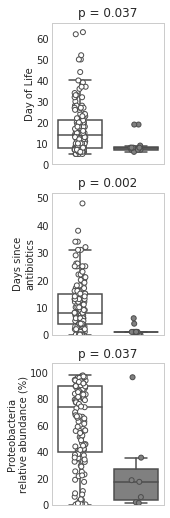

In [27]:
Fdb = Gdb.copy()
Fdb = pd.merge(Gdb, RASdb, on='sample')
Fdb = Fdb[ISTdb['explVar'].tolist() + ['Euk']]
# Fdb = pd.melt(Fdb, id_vars=['Euk'])
# Fdb = Fdb[Fdb['value'] < 1000]

n2n = {'DOL':'Day of Life',\
      'daysSinceAb':'Days since\nantibiotics',\
      'pp_pcov|Proteobacteria':'Proteobacteria\nrelative abundance (%)'}
n2l = {'DOL':'day of life',\
      'daysSinceAb':'number of days',\
      'pp_pcov|Proteobacteria':'relative abundance (%)'}

db = Fdb
label = 'Euk'
to_show = Fdb.columns
db.sort_values('Euk', inplace=True, ascending=False)

for i, pl in enumerate(to_show):
    if pl == 'Euk':
        continue
        
    plt.subplot(len(to_show), 1, i+1)
    fdb = db[~db[label].isna()]
    fdb = fdb[fdb[pl] < 1000]
    
    sns.boxplot(data=fdb, y=pl, x=label, showfliers=False, palette=['white', 'grey'])
    sns.stripplot(data=fdb, x=label, y=pl, \
          jitter=True, linewidth=1, size=5, edgecolor='gray', palette=['white', 'grey'])

    plt.gca().yaxis.grid(False)
    #plt.xlabel('p = {0:.3f}'.format(ISTdb['q'][ISTdb['explVar'] == pl].tolist()[0]))
    plt.xlabel('')
    plt.title('p = {0:.3f}'.format(ISTdb['q'][ISTdb['explVar'] == pl].tolist()[0]))
    plt.xticks([])
    plt.ylim(0,)
    #plt.title(n2n[pl.split('$')[2]])
    #plt.ylabel(n2l[pl.split('$')[2]])
    plt.ylabel(n2n[pl.split('$')[2]])
    plt.gca().yaxis.labelpad=1

plt.subplots_adjust(wspace=0.5)
plt.gcf().set_size_inches(2, 3*(len(to_show)))

#plt.savefig(fig_loc + 'FigureC_C.3.pdf', bbox_inches='tight')
plt.show()